batch size : 64  
epoch 40  
feature extractor : efficientnet b0  
augmentation : resize(224x224), sharpness
score : 0.7931 (best : 0.8326)

## Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import random
import pandas as pd
import numpy as np
import os
from PIL import Image
import pickle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.models import resnet18
from torchvision import transforms


from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [5]:
CFG = {
    'IMG_HEIGHT_SIZE':64,
    'IMG_WIDTH_SIZE':224,
    'EPOCHS':20,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':64,
    'NUM_WORKERS':4, # 본인의 GPU, CPU 환경에 맞게 설정
    'SEED':41
}

## Fixed RandomSeed

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load & Train/Validation Split

In [7]:
os.chdir('/content/drive/MyDrive')

In [8]:
os.getcwd()

'/content/drive/MyDrive'

In [9]:
df = pd.read_csv('./train.csv')

In [10]:
# 제공된 학습데이터 중 1글자 샘플들의 단어사전이 학습/테스트 데이터의 모든 글자를 담고 있으므로 학습 데이터로 우선 배치
df['len'] = df['label'].str.len()
train_v1 = df[df['len']==1]

In [11]:
# 제공된 학습데이터 중 2글자 이상의 샘플들에 대해서 단어길이를 고려하여 Train (80%) / Validation (20%) 분할
df = df[df['len']>1]
train_v2, val, _, _ = train_test_split(df, df['len'], test_size=0.2, random_state=CFG['SEED'])

In [12]:
# 학습 데이터로 우선 배치한 1글자 샘플들과 분할된 2글자 이상의 학습 샘플을 concat하여 최종 학습 데이터로 사용
train = pd.concat([train_v1, train_v2])
print(len(train), len(val))

66251 10637


In [13]:
with open('train.pickle', 'rb') as data:
    train_img = pickle.load(data)  
with open('test.pickle', 'rb') as data:
    test_img = pickle.load(data)  

In [14]:
train_img2 = []

for i in train.index:
  train_img2.append(train_img[i])

In [15]:
val_img = []

for i in val.index:
  val_img.append(train_img[i])

In [16]:
print(len(train_img2), len(val_img))

66251 10637


## Get Vocabulary

In [17]:
# 학습 데이터로부터 단어 사전(Vocabulary) 구축
train_gt = [gt for gt in train['label']]
train_gt = "".join(train_gt)
letters = sorted(list(set(list(train_gt))))
print(len(letters))

2349


In [18]:
vocabulary = ["-"] + letters
print(len(vocabulary))
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}
char2idx = {v:k for k,v in idx2char.items()}

2350


## CustomDataset

In [19]:
class CustomDataset(Dataset):
    def __init__(self, img_list, label_list, train_mode=True):
        self.img_list = img_list
        self.label_list = label_list
        self.train_mode = train_mode
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        image = self.img_list[index]
        
        if self.train_mode:
            image = self.train_transform(image)
        else:
            image = self.test_transform(image)
            
        if self.label_list is not None:
            text = self.label_list[index]
            return image, text
        else:
            return image
    
    # Image Augmentation
    def train_transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((CFG['IMG_WIDTH_SIZE'],CFG['IMG_WIDTH_SIZE'])),
            #transforms.RandomAdjustSharpness(2),
            transforms.GaussianBlur(kernel_size = (5,5), sigma = (0.1, 2)),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ]) #RandomAdjustSharpness, GaussianBlur
        return transform_ops(image)
    
    def test_transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((CFG['IMG_WIDTH_SIZE'],CFG['IMG_WIDTH_SIZE'])),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [20]:
train_dataset = CustomDataset(img_list=train_img2, label_list=train['label'].values)
#train_dataset = CustomDataset(train['img_path'].values, train['label'].values)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=CFG['NUM_WORKERS'])

val_dataset = CustomDataset(img_list=val_img, label_list=val['label'].values)
#val_dataset = CustomDataset(val['img_path'].values, val['label'].values)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=CFG['NUM_WORKERS'])

In [21]:
len(train_dataset)

66251

Text(0.5, 1.0, '깬')

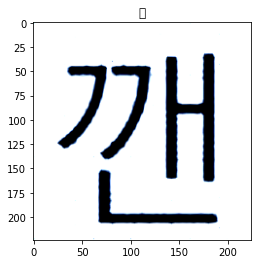

In [22]:
plt.imshow((train_dataset[35][0]).permute(1,2,0))
plt.title(train_dataset[35][1])

In [23]:
image_batch, text_batch = next(iter(train_loader))
print(image_batch.size(), text_batch)

torch.Size([64, 3, 224, 224]) ('전기밥솥', '수', '수출', '예상하다', '힘들어하다', '관련', '차선', '벗다', '하다', '지방', '싸다', '우유', '우려', '곡식', '꼬리', '고구마', '춤', '짙다', '숟가락', '순수', '겁나다', '고작', '자연스럽다', '연결되다', '역사학', '현관', '색', '뭣', '근원', '수영', '잽', '달리다', '아니', '선원', '농사일', '좋아', '층', '소비하다', '마련되다', '이십', '가깝다', '샘', '끗', '틈', '상대', '렷', '갖다', '럿', '무리하다', '그것', '술', '통', '좋다', '결혼', '뒨', '아아', '가득', '판', '앞바다', '대', '깔끔하다', '있다', '기후', '닭')


## Model Define

In [24]:
pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 21.6 MB/s eta 0:00:00


In [25]:
import timm

In [26]:
eff0 = timm.create_model(model_name='efficientnet_b0', pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


In [ ]:
# for param in eff0.parameters():
#     param.requires_grad_(False)

In [27]:
class RecognitionModel(nn.Module):
    def __init__(self, num_chars=len(char2idx), rnn_hidden_size=256):
        super(RecognitionModel, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
    
        # CNN Backbone = 사전학습된 Efficientnet 활용
        # https://arxiv.org/abs/1905.11946
        #eff0 = timm.create_model(model_name='efficientnet_b0', pretrained=True)
        # CNN Feature Extract
        #eff_modules = list(eff.children())[:-4]
        eff_modules = list(eff0.children())[:-2]
        self.feature_extract = nn.Sequential(
            *eff_modules,
            
        )
        
        self.linear1 = nn.Linear(8960, rnn_hidden_size)
        
        # RNN
        self.rnn = nn.RNN(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
    def forward(self, x):

        
        # CNN
        x = self.feature_extract(x) # [batch_size, channels, height, width]
        x = x.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
         
        batch_size = x.size(0)
        T = x.size(1)
        x = x.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        x = self.linear1(x)
        
        # RNN
        x, hidden = self.rnn(x)
        
        output = self.linear2(x)
        output = output.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        
        return output

## Define CTC Loss

In [28]:
criterion = nn.CTCLoss(blank=0) # idx 0 : '-'

In [29]:
def encode_text_batch(text_batch):
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [30]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 

    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

## Train

In [31]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    
    best_loss = 999999
    best_model = None
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for image_batch, text_batch in tqdm(iter(train_loader)):
            image_batch = image_batch.to(device)
            
            optimizer.zero_grad()
            
            text_batch_logits = model(image_batch)
            loss = compute_loss(text_batch, text_batch_logits)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        _train_loss = np.mean(train_loss)
        
        _val_loss = validation(model, val_loader, device)
        print(f'Epoch : [{epoch}] Train CTC Loss : [{_train_loss:.5f}] Val CTC Loss : [{_val_loss:.5f}]')
        
        if scheduler is not None:
            scheduler.step(_val_loss)
        
        if best_loss > _val_loss:
            best_loss = _val_loss
            best_model = model
    
    return best_model

## Validation

In [32]:
def validation(model, val_loader, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for image_batch, text_batch in tqdm(iter(val_loader)):
            image_batch = image_batch.to(device)
            
            text_batch_logits = model(image_batch)
            loss = compute_loss(text_batch, text_batch_logits)
            
            val_loss.append(loss.item())
    
    _val_loss = np.mean(val_loss)
    return _val_loss

## Run!!

In [ ]:
#model = RecognitionModel()
#model.eval()
#optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

In [ ]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()

19682

In [ ]:
model = RecognitionModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

In [46]:
infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [1] Train CTC Loss : [0.00611] Val CTC Loss : [0.06928]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [2] Train CTC Loss : [0.00575] Val CTC Loss : [0.07683]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [3] Train CTC Loss : [0.00635] Val CTC Loss : [0.06865]
Epoch 00023: reducing learning rate of group 0 to 6.2500e-05.


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [4] Train CTC Loss : [0.00388] Val CTC Loss : [0.06279]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [5] Train CTC Loss : [0.00286] Val CTC Loss : [0.06577]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [6] Train CTC Loss : [0.00189] Val CTC Loss : [0.05970]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [7] Train CTC Loss : [0.00186] Val CTC Loss : [0.06307]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [8] Train CTC Loss : [0.00171] Val CTC Loss : [0.05963]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [9] Train CTC Loss : [0.00143] Val CTC Loss : [0.06089]
Epoch 00029: reducing learning rate of group 0 to 3.1250e-05.


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [10] Train CTC Loss : [0.00119] Val CTC Loss : [0.05899]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [11] Train CTC Loss : [0.00095] Val CTC Loss : [0.06014]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [12] Train CTC Loss : [0.00073] Val CTC Loss : [0.05879]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [13] Train CTC Loss : [0.00081] Val CTC Loss : [0.05871]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [14] Train CTC Loss : [0.00077] Val CTC Loss : [0.05838]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [15] Train CTC Loss : [0.00065] Val CTC Loss : [0.05982]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [16] Train CTC Loss : [0.00062] Val CTC Loss : [0.05871]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [17] Train CTC Loss : [0.00063] Val CTC Loss : [0.05789]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [18] Train CTC Loss : [0.00048] Val CTC Loss : [0.05931]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [19] Train CTC Loss : [0.00051] Val CTC Loss : [0.05919]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [20] Train CTC Loss : [0.00049] Val CTC Loss : [0.06110]
Epoch 00040: reducing learning rate of group 0 to 1.5625e-05.


In [47]:
torch.save(infer_model.state_dict(), 'model_0108_40.pt')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/model_0108_20.pt'))
model.eval()
model.to(device)

RecognitionModel(
  (feature_extract): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

## Inference

In [35]:
test = pd.read_csv('./test.csv')

In [36]:
len(test)

74121

In [37]:
test_dataset = CustomDataset(test_img, None)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=CFG['NUM_WORKERS'])

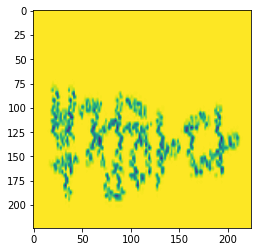

In [38]:
plt.imshow(test_dataset[74120][0])

In [40]:
image_batch, text_batch = next(iter(test_loader))
print(image_batch.size(), text_batch)

ValueError: ignored

In [41]:
def decode_predictions(text_batch_logits):
    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for image_batch in tqdm(iter(test_loader)):
            image_batch = image_batch.to(device)
            
            text_batch_logits = model(image_batch)
            
            text_batch_pred = decode_predictions(text_batch_logits.cpu())
            
            preds.extend(text_batch_pred)
    return preds

In [48]:
predictions = inference(infer_model, test_loader, device)

  0%|          | 0/1159 [00:00<?, ?it/s]

## Submission

In [43]:
# 샘플 별 추론결과를 독립적으로 후처리
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [49]:
submit = pd.read_csv('./sample_submission.csv')
submit['label'] = predictions
submit['label'] = submit['label'].apply(correct_prediction)

In [50]:
submit.to_csv('./submission.csv', index=False)

https://github.com/craftsangjae/ocr-text-recognition-korean  

https://github.com/clovaai/deep-text-recognition-benchmark